In [1]:
import numpy as np
import scipy.sparse as sp
from mpl_toolkits import mplot3d
from rom_am import DMDc, ROM, DMD
import matplotlib.pyplot as plt

## Unstable Linear system

We consider the following unstable linear system:

$$
\begin{pmatrix}
x_1  \\
x_2 \\
\end{pmatrix}_{k+1} = \begin{pmatrix}
1.5 & 0  \\
0 & 0.1 \\
\end{pmatrix} \begin{pmatrix}
x_1  \\
x_2 \\
\end{pmatrix}_{k} + \begin{pmatrix}
-3  \\
0 \\
\end{pmatrix} u_k $$

Which should be modeled correctly by the DMD with control (DMDc), (of which the Affine DMD is a special case, when the input is fixed) whereas it can't be using the classical DMD.

We will use the DMDc to learn $\pmb{b} = \begin{pmatrix}
-3  \\
0 \\
\end{pmatrix}$ as well as the system matrix $\pmb{A}$

**Creating the snapshots**

In [2]:
X = np.zeros((2, 4))
Y = np.zeros((2, 4))
X[:, 0] = np.array([4, 7])

A = np.array([[1.5, 0], [0, 0.1]])
B = np.array([-3, 0]).reshape((-1, 1))
u = np.ones(4)

Y[:, 0] = A @ X[:, 0] + B.ravel() * u[0]
for i in range(Y.shape[1]-1):
    Y[:, i+1] = A @ Y[:, i] + B.ravel() * u[i]
X[:, 1::] = Y[:, :-1]

**DMDc Learning**

We train the DMDc model on the extracted snapshots

In [3]:
#u_input = np.ones((1, X.shape[1]))
u_input = u.reshape((1, -1))
dt = 10
rank = 0
dmdc = DMDc()
dromc = ROM(dmdc)
dromc.decompose(X,  Y = Y, dt = dt, rank =rank, Y_input=u_input)

We can show now the learned matrix $\pmb{A}$

In [4]:
dromc.model.A

array([[ 1.50000000e+00, -6.66132691e-16],
       [-4.92613273e-17,  1.00000000e-01]])

and the learned matrix $\pmb{b}$

In [5]:
dromc.model.B

array([[-3.00000000e+00],
       [ 5.55111512e-17]])

-------------------------------------------------------------------------------------------------------------------------------------------------

**Question : Can DMD learn it too ?**

Obviously, classical DMD is not able to learn a $\pmb{X}^{k+1} = \pmb{A} \pmb{X}^{k} + \pmb{b}$. And it approximates it through a $\pmb{X}^{k+1} = \pmb{A} \pmb{X}^{k}$ model

In [6]:
u_input = u.reshape((1, -1))
dt = 10
rank = 0
dmd_ = DMD()
drom_ = ROM(dmd_)
drom_.decompose(X,  Y = Y, dt = dt, rank =rank,)

$\pmb{A}$ = 

In [7]:
drom_.model.A

array([[5.39578170e-01, 1.14627842e-01],
       [1.11900706e-16, 1.00000000e-01]])

In [8]:
error_dmd = np.linalg.norm(Y - drom_.model.A @ X)
error_dmdc = np.linalg.norm(Y - (dromc.model.A @ X + dromc.model.B @ u_input))

In [9]:
print("DMD error : "+ str(error_dmd)+"\nDMDc error : "+str(error_dmdc))

DMD error : 4.04284239297286
DMDc error : 2.3337360971660245e-15


------------------------------------------------------------------------------------------------------------------------

Answer : In this case, **No**

**DMDc Prediction**

We now make prediction using the learned DMDc model (the time vector is irrelevant in this case)

We use here the reduced model (projection on POD of $\pmb{X}$)

$$\tilde{\pmb{x}}_{k+1} = \tilde{\pmb{A}} \tilde{\pmb{x}}_{k}+ \tilde{\pmb{b}}$$

In [10]:
t = np.arange(0, 200, dt)
predicted_X = np.real(dromc.predict(t, t1 = t[0], u_input = np.ones((1, t.shape[0]))))

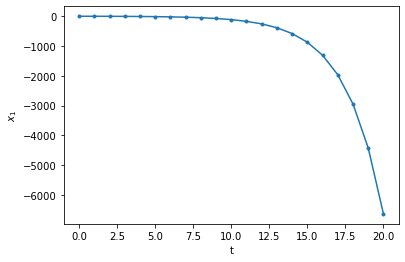

In [11]:
plt.plot(predicted_X[0, :], '.-');
plt.ylabel(r"$x_1$");
plt.xlabel('t');

(Unstable System) ($\lambda_1 = 1.5$)

------------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

On the above case, we have no information on the continuous according system. We will test DMDc (Affine) on another similar system and experiment different prediction strategies

## Another Linear system


$$
\begin{pmatrix}
\dot{x_1}(t)  \\
\dot{x_2}(t)  \\
\end{pmatrix} = \begin{pmatrix}
-1.7 & 2  \\
0.2 & -1 \\
\end{pmatrix} \begin{pmatrix}
x_1(t)  \\
x_2(t) \\
\end{pmatrix}_{k} + \begin{pmatrix}
-0.2  \\
0 \\
\end{pmatrix} u_k $$

We will then obtain snapshots of $\pmb{X}_c$ and $\pmb{Y}_c$ through numerical integration through `scipy.integrate.solve_ivp` (MATLAB's `ode45`-like)

In [12]:
cont_A = np.array([[-1.7, 2], [0.2, -1]])
cont_B = np.array([-1.2, 0])

import scipy.linalg as scia
from scipy.integrate import solve_ivp
def f(t, y): return cont_A @ y + cont_B
sample_dt = 0.05
t_eval = np.arange(0, 5.05, step = sample_dt)
sol = solve_ivp(f, [0, 5.], np.array([0.5, 4.]), t_eval = t_eval)

We obtain the analogous discrete matrices through
$$
\begin{pmatrix}
\dot{x}(t)  \\
\dot{u}(t)  \\
\end{pmatrix} = \pmb{M} \begin{pmatrix}
{x(t)}  \\
{u(t)}  \\
\end{pmatrix} = \begin{pmatrix}
cont\_A & cont\_B  \\
0 & 0 \\
\end{pmatrix} \begin{pmatrix}
{x(t)}  \\
{u(t)}  \\
\end{pmatrix} $$

and 
$$
\pmb{F} = e^{\pmb{M}  \Delta t} = \begin{pmatrix}
A & B \\
0 & 1 \\
\end{pmatrix} $$

Choosing $\Delta t = 0.05$

In [13]:
M = scia.expm(np.block([[cont_A, cont_B.reshape((-1, 1))], [np.zeros((1, 2)), np.zeros((1, 1))]]) * sample_dt)

A = M[:2, :2]
B = M[:2, -1]

In [14]:
print("A = ", A, "\nB = ", B)

A =  [[0.91897698 0.09349312]
 [0.00934931 0.95169958]] 
B =  [-0.05753021 -0.00028687]


**Creation of discrete snapshots  $\pmb{X}$ and $\pmb{Y}$**

The same approach as the previous case. We sample these snapshots on $t = [0, 1.95]$ equally sampled by $\Delta t$

In [15]:
X = np.zeros((2, sol.t.shape[0]))
Y = np.zeros((2, sol.t.shape[0]))
X[:, 0] = np.array([0.5, 4.])

u = np.ones(sol.t.shape[0])

Y[:, 0] = A @ X[:, 0] + B.ravel() * u[0]
for i in range(Y.shape[1]-1):
    Y[:, i+1] = A @ Y[:, i] + B.ravel() * u[i]
X[:, 1::] = Y[:, :-1]

t = t_eval.copy()

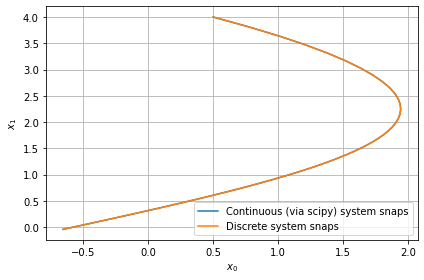

In [16]:
plt.plot(sol.y[0, :], sol.y[1, :], label = "Continuous (via scipy) system snaps");
plt.plot(X[0, :], X[1, :], label = "Discrete system snaps");
plt.xlabel("$x_0$");
plt.ylabel("$x_1$");
plt.legend();
plt.grid();
plt.tight_layout();

**DMDc (Affine) Learning**

In [17]:
u_input = np.ones((1, X.shape[1]))
rank = 0
dmdc = DMDc()
dromc = ROM(dmdc)
dromc.decompose(X,  Y = Y, dt = sample_dt, rank =rank, Y_input=u_input)

**DMDc Prediction**

As before, we predict the solution through the discrete approach, on **obligatorily equally sampled timesteps** $t=[0, 3.9s]$ $$\tilde{\pmb{x}}_{k+1} = \tilde{\pmb{A}} \tilde{\pmb{x}}_{k}+ \tilde{\pmb{b}}$$

In [18]:
t_pred = t_eval.copy()

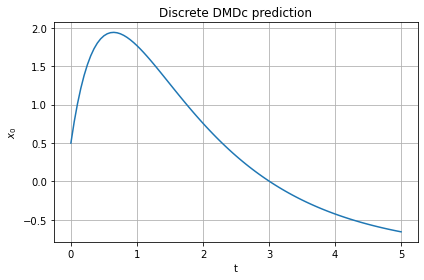

In [19]:
predicted_X_1 = np.real(dromc.predict(t_pred, t1 = t[0], u_input = np.ones((1, t_pred.shape[0]-1))))
plt.plot(t_pred, predicted_X_1[0, :]);
plt.title("Discrete DMDc prediction");
plt.grid();
plt.xlabel('t');
plt.ylabel('$x_0$');
plt.tight_layout();